In [4]:
classes = ["Arson", "Assault", "Fighting", "RoadAccidents", "Shooting", "Stealing", "Vandalism", "Normal"]

In [13]:
import numpy as np

y_test = []
y_score = []
with open("test.txt", "r") as f:
    lines = [line.strip() for line in f.readlines()]
    for line in lines:
        filler, video, probabilties = [p.strip() for p in line.split("|")]
        for c in classes:
            if(c in video):
                true_class = c
        probabilties = probabilties.split(" ")
        prob_arr = [float(s) for s in probabilties]
        y_test.append(true_class)
        y_score.append(prob_arr)
y_score = np.array(y_score)

In [6]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np

label_binarizer = LabelBinarizer().fit(classes)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
# for c in classes:
#     print(c, label_binarizer.transform([c]))

# class_of_interest = "Normal"
# class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
# class_id

(40, 8)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np

for c in classes:
    class_of_interest = c
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id

    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="One-vs-Rest ROC curves:\n%s vs Rest"%(c),
    )

In [8]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(classes)):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.62
Macro-averaged One-vs-Rest ROC AUC score:
0.63


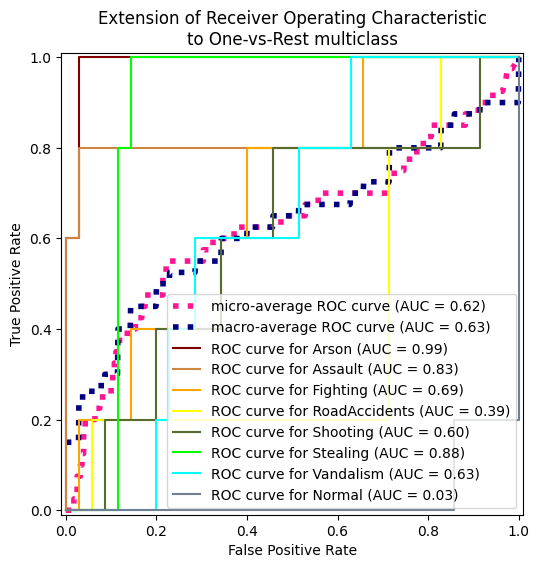

In [9]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["maroon", "peru", "orange", "yellow", "darkolivegreen", "lime", "aqua", "slategrey", "blue"])
for class_of_interest, color in zip(classes, colors):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_of_interest}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)